<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Anticipez les besoins en consommation de bâtiments
    Projet 4 Notebook deuxième itération de modélisation pour l'émission de gaz et l’intérêt de Energy star score</h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

<a name="top"></a>

# Sommaire :

**Partie 1**

 - <a href="#C1"> 1.1 Importation des librairies</a>
 - <a href="#C2"> 1.2 Les fonctions </a>
 - <a href="#C3"> 1.3 Importation des données</a>
 
**Partie 2 : Prédiction de l'émission de gaz**
 - <a href="#C4"> Prédiction de l'émission de gaz</a>
 - <a href="#C6"> 2.1 Preprocessing (transformation en log, split data, encoding et standardisation)</a>
 - <a href="#C7"> 2.2 Linear Regression et les autres modèles Baseline et Cross validation 
 - <a href="#C8"> 2.3 Lasso Regression 
 - <a href="#C9"> 2.4 Support Vector Regression (SVR)</a>
 - <a href="#C10"> 2.5 Adaboost (baseline, RFE, Gridsearch, feature importance et leaning curve)</a>
 - <a href="#C11"> 2.6 Random Forest (baseline, RFE, Gridsearch, feature importance et leaning curve)</a>
 - <a href="#C12"> 2.7 Comparaison des résultats pour la consommation d'énergie</a>
 
**Partie 3 : Les Analyses pour Energy Star Score**
 - <a href="#C5"> Les Analyses pour Energy Star Score</a>
 - <a href="#C13"> 3.1 Les Analyses Sans Energy Star Score</a>
 - <a href="#C14"> 3.1.1 Linear Regression et les autres modèles Baseline et Cross validation 
 - <a href="#C15"> 3.1.2 Random Forest (baseline, RFE et Gridsearch)</a>
 - <a href="#C16"> 3.2 Les Analyses Avec Energy Star Score</a>
 - <a href="#C17"> 3.2.1 Linear Regression et les autres modèles Baseline et Cross validation</a>
 - <a href="#C18"> 3.2.2 Random Forest (baseline, RFE et Gridsearch)</a>
 - <a href="#C19"> 3.3 Comparaison final de la consommation sans et avec Energy Star Score
 
**Partie 4 : Conclusion et recommandations**
 - <a href="#C20"> Conclusion et recommandations </a> 

# <a name="C1"> 1.1 Importation des librairies</a>
<a href="#top">sommaire</a>

In [1]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p4/new'

In [2]:
# Installation des libraries

# !pip install pandas
# !pip install missingno 
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy 

In [3]:
# Importation des libraries
import sys
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import sklearn
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV
from sklearn.impute import KNNImputer

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

In [4]:
# Les versions des libraries
print("Python: ", sys.version)
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Missingno: ", msno.__version__)
print("Sklearn: ",sklearn.__version__)

Python:  3.8.16 (default, Mar  1 2023, 21:19:10) 
[Clang 14.0.6 ]
Pandas:  1.5.3
Numpy:  1.23.5
Seaborn:  0.12.2
Matplotlib:  3.7.1
Missingno:  0.5.2
Sklearn:  1.2.2


In [5]:
# Les options pour visualisations des dataframes
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 1200)
#pd.set_option('display.max_rows', 200)

# <a name="C2"> 1.2 Les fonctions</a>
<a href="#top">sommaire</a>

In [6]:
def heatmap(data):
    sns.set(font_scale=1.2)
    fig = plt.figure(figsize=(20,8))
    matrix = data.corr()
    plt.title("Le Heatmap de la Data", size=25)
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", mask=mask)
    plt.xticks(rotation=90);
    return 

In [7]:
def train_evaluate_models2(models, X_train, y_train, X_test, y_test):
    seed = 0
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    results = []
    for model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        r2_train = r2_score(y_train, y_pred_train).round(2)
        scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=kfold)
        r2_test = r2_score(y_test, y_pred_test).round(2)
        mse = mean_squared_error(y_test, y_pred_test).round(2)
        mae = mean_absolute_error(y_test, y_pred_test).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred_test).round(2)
        rmse = np.sqrt(mse).round(2)
        #rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred_test) - np.log1p(y_test)))).round(2)
        exec_time = end_time - start_time
        results.append({'model': model.__class__.__name__,
                        'r2_train': r2_train,
                        'cv_mean' : np.mean(scores).round(2),
                        'r2_test': r2_test,
                        'mean_absolute_error': mae,
                        'mean_absolute_percentage_error': mape,
                        'RMSE': rmse,
                        #'RMSLE': rmsle,
                        'training_time': exec_time})
        print("Cross val R2 values for model", model.__class__.__name__, ": ", scores.round(2)) 
    return pd.DataFrame(results)

In [8]:
def plot_coefficients(model, feature_names):
    """
    Plots the coefficients of a linear regression, Lasso regression, or Ridge regression model using a bar plot.
    
    Parameters:
    -----------
    model : LinearRegression, Lasso, or Ridge object
        The regression model to plot the coefficients for.
    feature_names : list of str
        The names of the input features used in the model.
    """
    # Get the coefficients of the model
    if isinstance(model, Lasso) or isinstance(model, Ridge) or (model, LinearRegression):   
        coefficients = model.coef_
    else:
        raise ValueError("Invalid model type. Must be LinearRegression, Lasso, or Ridge.")
    
    # Create a bar plot of the coefficients
    plt.barh(range(len(coefficients)), coefficients)
    plt.yticks(range(len(coefficients)), feature_names)
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Coefficients')
    plt.show()

In [9]:
# Affichage des features importance
def show_feature_importance(model,  X_train, name):
    
    feat_imp = model.feature_importances_
    df_feat_imp = pd.DataFrame(feat_imp, columns = ["Feature Importance"])
    df_feat_imp["Feature Name"] = X_train.columns
    df_feat_imp = df_feat_imp.sort_values(by="Feature Importance", ascending=False)
    display(df_feat_imp)   
    # Affichage Features importance
    plt.barh(df_feat_imp["Feature Name"], df_feat_imp["Feature Importance"])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature importance pour le modele {name} ")
    plt.show()
    return None

In [10]:
def gridsearch_model(X_train, y_train, model, params):
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid=params, cv=kfold, scoring="r2", refit=True)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    end_time = time.time()
    exec_time = end_time - start_time
    print('Best hyperparameters for', model, ':', grid_search.best_params_)
    print("Best score for", model, ":", grid_search.best_score_ )
    print("Gridsearch time: ",exec_time, "s")
    return best_model

In [11]:
def my_learning_curve(model, X_train, y_train):
    train_sizes = np.linspace(0.2, 1.0, 10)
    
    # Calculate the learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='r2')
    
    # Calculate the mean of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("r2 score")
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt.show()

In [12]:
def rfe_graph(model, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=kfold, scoring='r2')
    rfecv.fit(X_train, y_train)
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    return plt.show()

In [13]:
# Select the best features according to RFE
def rfe_features(model, n_features_to_select, X_train, y_train):
    rfe_rf = RFE(model, n_features_to_select=n_features_to_select)
    rfe_rf.fit(X_train, y_train)
    selected_features = list(X_train.columns[rfe_rf.support_])
    print("selected_features:", selected_features)
    return selected_features

In [14]:
def plot_scores(data):
    x = np.arange(len(data.index))
    width = 0.37
    fig, ax = plt.subplots(figsize=(15, 7))
    scores_tr = ax.bar(x - width/2, data['r2_train'], width, label='Train')
    scores_cv = ax.bar(x + width/2, data['cv_mean'], width, label='Cross_val_mean')
    ax.set_ylabel('R2 Score')
    ax.set_title('Comparaison des scores sur le train et le cross validation set par modèle', fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(data['model'])
    ax.legend()
    ax.bar_label(scores_tr, padding=0.1)
    ax.bar_label(scores_cv, padding=0.1)
    fig.tight_layout()
    plt.show()

In [15]:
def plot_training_times(data):
    x = np.arange(len(data.index))
    width = 0.37
    fig, ax = plt.subplots(figsize=(15, 7))
    times = ax.bar(x, data['training_time'], width, label='training_time')
    ax.set_ylabel('temps en seconds')
    ax.set_title("Comparaison des temps d'entrainnement", fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(data['model'])
    ax.legend()
    ax.bar_label(times, padding=0.1, fmt='%.3f')
    fig.tight_layout()
    plt.show()

# Comme nous avons déjà effectué les explications des modèles et des hyperparamètres dans le notebook d'analyse exploratoire et de première itération, nous allons nous concentrer davantage sur les résultats dans ce notebook.

# <a name="C3"> 1.3 Importation des données</a>
<a href="#top">sommaire</a>

In [16]:
data_large = pd.read_csv("data_large_use_rate.csv")
data_large.head(3)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SiteEUIWN(kBtu/sf),Steam_Use_Rate,SiteEnergyUseWN(kBtu),Elec_Use_Rate,Natural_Use_Rate,TotalGHGEmissions,GHGEmissionsIntensity,ENERGYSTARScore,NofBuildings,NofFloors,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,LargestPropertyUseTypeGFA,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,1,NonResidential,Hotel,98101.0,96,1.0,12.0,88434,0,84.300003,26.872820,7456910.0,52.917723,17.117720,249.98,2.83,60.0,unibuilding,lowbuilding,7,DOWNTOWN,Hotel,88434.0,2627.000084,0.000000,7369.500000,88434.0,1.000000
1,2,NonResidential,Hotel,98101.0,27,1.0,11.0,103566,15064,97.900002,0.000000,8664479.0,37.426959,59.381320,295.86,2.86,61.0,unibuilding,lowbuilding,7,DOWNTOWN,Hotel,83880.0,2582.229311,14.545314,9415.090909,103566.0,0.809918
2,3,NonResidential,Hotel,98101.0,54,1.0,41.0,956110,196718,97.699997,29.168781,73937112.0,66.984851,2.020366,2089.28,2.19,43.0,unibuilding,highbuilding,7,DOWNTOWN,Hotel,756493.0,3184.522679,20.574829,23319.756098,956110.0,0.791220


In [17]:
data_large.shape

(1642, 28)

# Nos targets
* Les émissions de gaz : TotalGHGEmissions
* ENERGY STAR Score : ENERGYSTARScore (L'évaluation de l'intérêt)

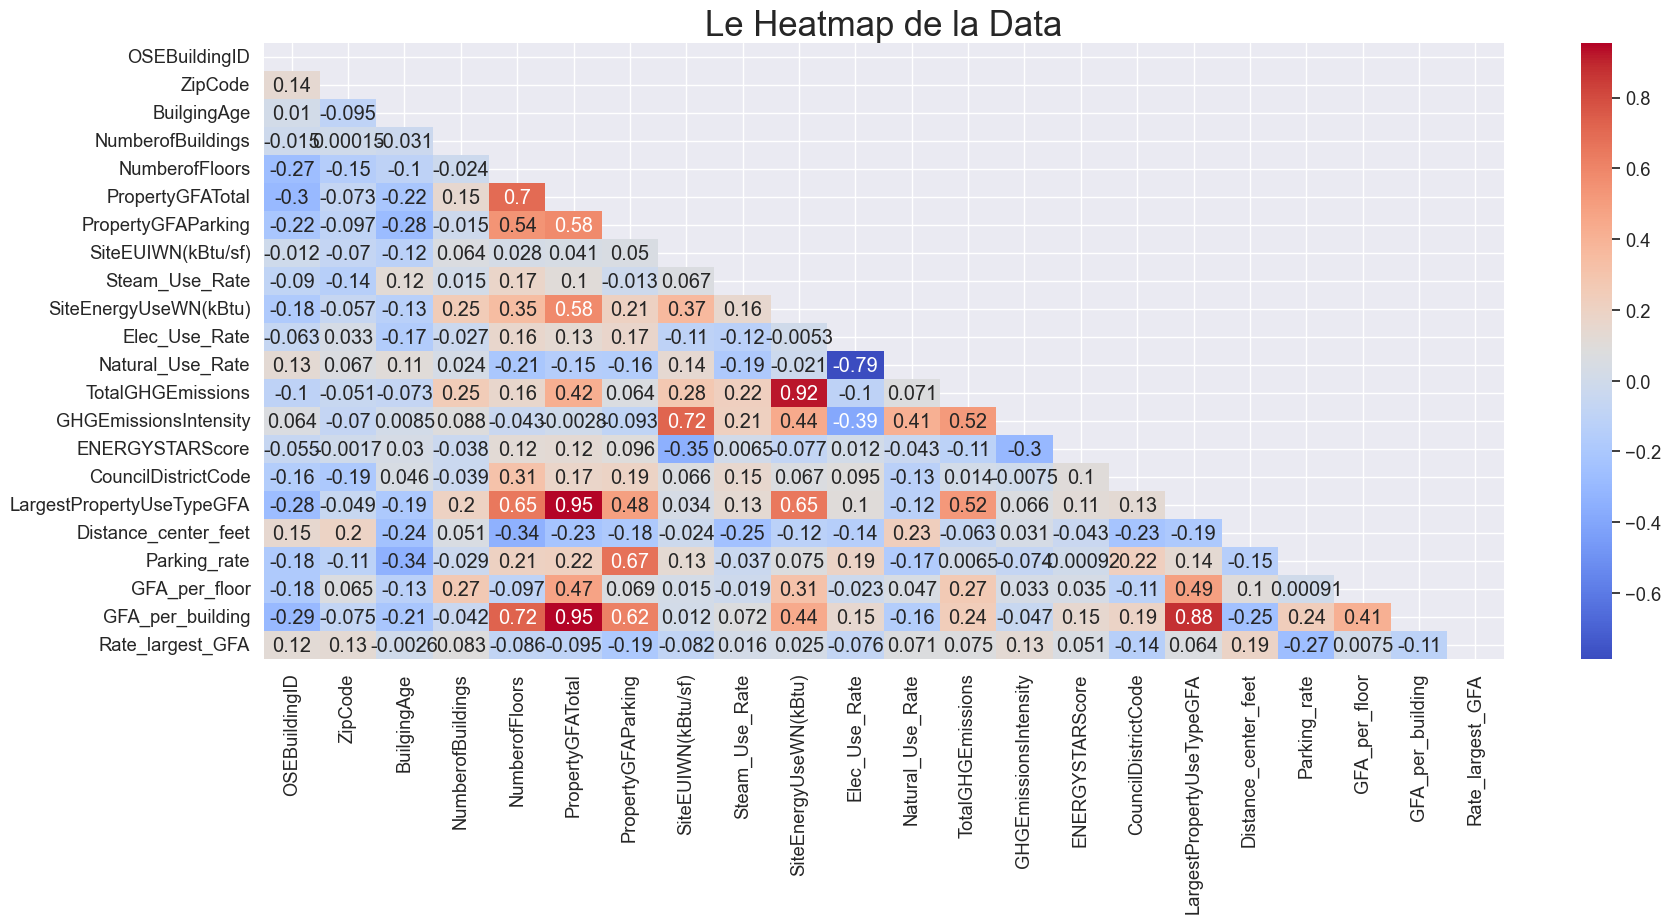

In [18]:
heatmap(data_large)

On constate des corrélations fortes entre certaines variables. Au cours de notre processus de modélisation, nous allons éliminer l'une de ces colonnes en raison de la présence de multicolinéarité, ce qui rend certains modèles instables.

# <a name="C4"> Prédiction de l'émission de gaz</a>
<a href="#top">sommaire</a>

## On va filtrer les colonnes qu'on a besoin pour nos analyses TotalGHGEmissions

In [19]:
drop_list_both = ["OSEBuildingID", "NumberofBuildings", 'NofFloors', 'NofBuildings', 'NumberofFloors',
                 "SiteEUIWN(kBtu/sf)", "GHGEmissionsIntensity", 'PropertyGFAParking', 'PropertyGFATotal',
                 'Elec_Use_Rate', 'LargestPropertyUseTypeGFA']                  

In [20]:
data_analyse_both = data_large.drop(drop_list_both , axis=1)
data_analyse_both.shape

(1642, 17)

In [21]:
# On va changer le type de Zipcode et CouncilDistrictCode
data_analyse_both['ZipCode'] = data_analyse_both['ZipCode'].astype('int')
data_analyse_both['ZipCode'] = data_analyse_both['ZipCode'].astype('object')
data_analyse_both['CouncilDistrictCode'] = data_analyse_both['CouncilDistrictCode'].astype('object')

In [22]:
result_log_gas = data_analyse_both.drop(["SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)
result_log_gas.head(2)

,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,Steam_Use_Rate,Natural_Use_Rate,TotalGHGEmissions,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,NonResidential,Hotel,98101,96,26.87282,17.11772,249.98,7,DOWNTOWN,Hotel,2627.000084,0.000000,7369.500000,88434.0,1.000000
1,NonResidential,Hotel,98101,27,0.00000,59.38132,295.86,7,DOWNTOWN,Hotel,2582.229311,14.545314,9415.090909,103566.0,0.809918


## <a name="C6"> 2.1 Preprocessing</a>
<a href="#top">sommaire</a>

In [23]:
X_gas = result_log_gas.drop("TotalGHGEmissions", axis=1)
y_gas = result_log_gas["TotalGHGEmissions"]

In [24]:
y_gas = np.log(y_gas)

In [25]:
# Split the data into training and test sets
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size=0.2, random_state=0)

In [26]:
categorical = X_train_gas.select_dtypes(include = "O").columns.tolist()
numerical = X_train_gas.select_dtypes(exclude = "O").columns.tolist()

In [27]:
#scaler = RobustScaler()
encoder = TargetEncoder()
scaler =  StandardScaler()

X_train_gas[categorical] = encoder.fit_transform(X_train_gas[categorical], y_train_gas)
X_test_gas[categorical] = encoder.transform(X_test_gas[categorical], y_test_gas)

X_train_gas = scaler.fit_transform(X_train_gas)
X_test_gas = scaler.transform(X_test_gas)
X_train_gas = pd.DataFrame(X_train_gas, columns=X_gas.columns)
X_test_gas = pd.DataFrame(X_test_gas, columns=X_gas.columns)

In [28]:
print(X_train_gas.shape)
X_train_gas.head(2)

(1313, 14)


,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,Steam_Use_Rate,Natural_Use_Rate,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,-0.300077,0.454181,-0.412478,-0.430536,-0.233666,-1.035616,-0.173277,-0.164639,0.646083,1.380271,-0.432629,-0.529156,-0.468503,0.485207
1,-0.300077,-1.005629,0.848879,-1.104415,-0.233666,-1.035616,1.003185,1.062184,-0.183327,-0.906862,0.966906,-0.265017,-0.120845,-0.231739


## <a name="C7"> 2.2 Linear Regression et les autres modèles Baseline et Cross validation </a>
<a href="#top">sommaire</a>

In [29]:
# Create 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [30]:
# Train and evaluate the models on the data
random_state = 0
models = [DummyRegressor(strategy="mean"),
          LinearRegression(),
          Lasso(),
          SVR(),
          RandomForestRegressor(random_state=random_state),
          AdaBoostRegressor(random_state=random_state)]
  # list of models to train and evaluate
results_nrj = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
# Display the results for comparison
display(results_nrj)

Cross val R2 values for model DummyRegressor :  [-0.02 -0.02 -0.   -0.   -0.  ]
Cross val R2 values for model LinearRegression :  [0.48 0.68 0.64 0.61 0.66]
Cross val R2 values for model Lasso :  [-0.02 -0.02 -0.   -0.   -0.  ]
Cross val R2 values for model SVR :  [0.72 0.72 0.71 0.72 0.7 ]
Cross val R2 values for model RandomForestRegressor :  [0.77 0.73 0.77 0.75 0.76]
Cross val R2 values for model AdaBoostRegressor :  [0.68 0.64 0.71 0.64 0.68]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,DummyRegressor,0.00,-0.01,-0.00,1.12,0.66,1.44,0.000261
1,LinearRegression,0.65,0.62,0.62,0.69,0.38,0.89,0.004084
2,Lasso,0.00,-0.01,-0.00,1.12,0.66,1.44,0.000902
3,SVR,0.79,0.71,0.71,0.57,0.29,0.78,0.100275
4,RandomForestRegressor,0.97,0.76,0.69,0.58,0.29,0.79,0.546393
5,AdaBoostRegressor,0.72,0.67,0.53,0.76,0.34,0.98,0.087753


## Linear Regression

In [31]:
model_lr = LinearRegression()
models = [model_lr]
result_lr_base = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_lr_base["model"] = "LinearRegression base"
result_lr_base

Cross val R2 values for model LinearRegression :  [0.48 0.68 0.64 0.61 0.66]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression base,0.65,0.62,0.62,0.69,0.38,0.89,0.002378


### Recursive Feature Elimination (RFE)

Optimal number of features : 10


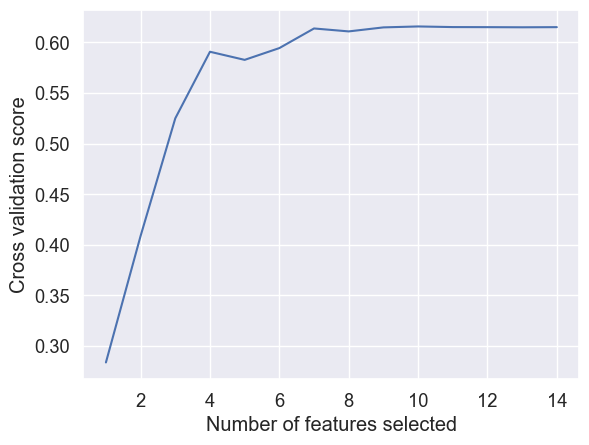

In [32]:
rfe_graph(model_lr, X_train_gas, y_train_gas)

In [33]:
# Select the best features according to RFE
selected_features = rfe_features(model_lr, 10, X_train_gas, y_train_gas)

selected_features: ['PrimaryPropertyType', 'ZipCode', 'BuilgingAge', 'Steam_Use_Rate', 'Natural_Use_Rate', 'LargestPropertyUseType', 'Distance_center_feet', 'Parking_rate', 'GFA_per_floor', 'GFA_per_building']


In [34]:
cols_lr = selected_features
models = [model_lr]
result_lr_rfe = train_evaluate_models2(models, X_train_gas[cols_lr], y_train_gas, X_test_gas[cols_lr], y_test_gas)
result_lr_rfe["model"] = "LinearRegression RFE"
result_lr_rfe

Cross val R2 values for model LinearRegression :  [0.49 0.68 0.65 0.62 0.66]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE,0.64,0.62,0.61,0.69,0.38,0.89,0.002332


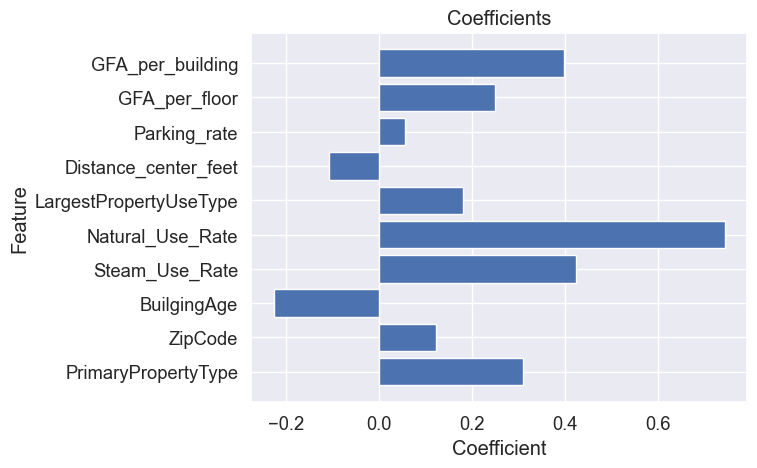

In [35]:
plot_coefficients(model_lr, X_train_gas[cols_lr].columns)

On constate que les variables le plus importantes pour le Linear Regression sont Steam_Use_Rate et Natural_Use_Rate

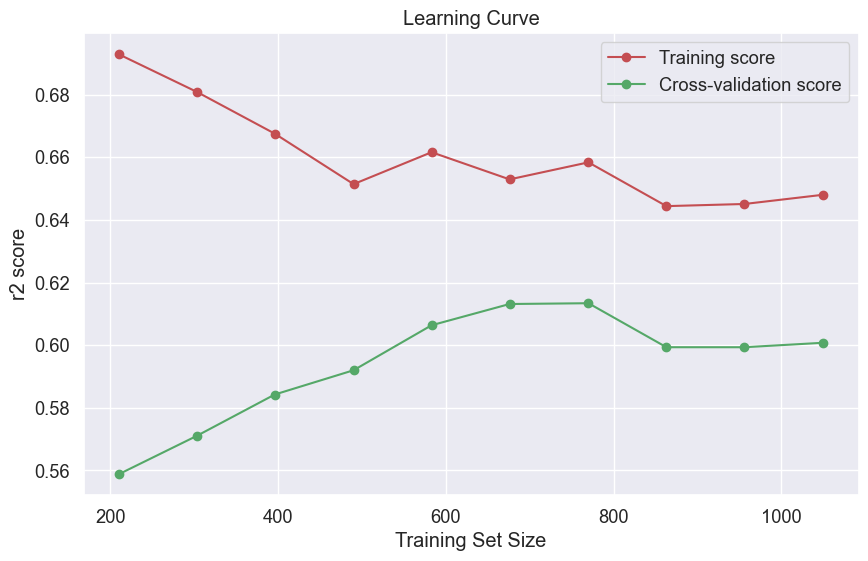

In [36]:
my_learning_curve(model_lr, X_train_gas, y_train_gas)

D'après le learning curve notre modèle besion encore de données

## Regularisation avec Lasso 

## <a name="C8"> 2.3 Lasso Regression </a>
<a href="#top">sommaire</a>

In [37]:
model_lcv = LassoCV(cv=kfold)
models = [model_lcv]
result_lcv = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_lcv["model"] = "LassoCV"
print("Alpha lasso_cv:", model_lcv.alpha_.round(2))
#selected_features = X_train_gas.columns[model_lcv.coef_ != 0]
result_lcv

Cross val R2 values for model LassoCV :  [0.49 0.67 0.64 0.62 0.65]
Alpha lasso_cv: 0.02


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LassoCV,0.64,0.61,0.61,0.69,0.38,0.89,0.02786


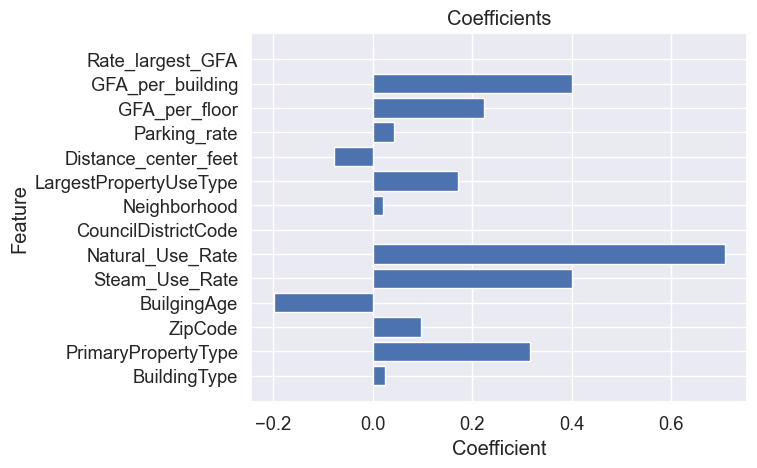

In [38]:
plot_coefficients(model_lcv, X_train_gas.columns)

On constate que les variables le plus importantes pour le modèle sont Steam_Use_Rate, Natural_Use_Rate et GFA_per_building

In [39]:
compare_linear = pd.concat([result_lr_base, result_lr_rfe, result_lcv], axis=0, ignore_index=True) 
compare_linear

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression base,0.65,0.62,0.62,0.69,0.38,0.89,0.002378
1,LinearRegression RFE,0.64,0.62,0.61,0.69,0.38,0.89,0.002332
2,LassoCV,0.64,0.61,0.61,0.69,0.38,0.89,0.027860


## <a name="C9"> 2.4 Support Vector Regression (SVR) </a>
<a href="#top">sommaire</a>

### SVR sans Hyperparametre Tuning

In [40]:
model_svr = SVR()
models = [model_svr]
result_model_svr = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_model_svr["model"] = "SVR sans tuning"
result_model_svr

Cross val R2 values for model SVR :  [0.72 0.72 0.71 0.72 0.7 ]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,SVR sans tuning,0.79,0.71,0.71,0.57,0.29,0.78,0.099346


## Hyperparametre Tuning Gridsearch pour SVR

In [41]:
svr_params = {'C': [0.001, 0.01, 0.5, 1, 1.5], 'epsilon': [0.07, 0.1, 0.2], 'kernel': ['linear', 'rbf']}
model_svr = SVR()
best_model_svr = gridsearch_model(X_train_gas, y_train_gas, model_svr, svr_params)

Best hyperparameters for SVR() : {'C': 1.5, 'epsilon': 0.07, 'kernel': 'rbf'}
Best score for SVR() : 0.719382136592238
Gridsearch time:  11.404527187347412 s


In [42]:
models = [best_model_svr]
result_svr_tuning = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_svr_tuning["model"] = "SVR Tuning"
result_svr_tuning

Cross val R2 values for model SVR :  [0.72 0.73 0.72 0.72 0.71]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,SVR Tuning,0.81,0.72,0.72,0.55,0.28,0.76,0.10519


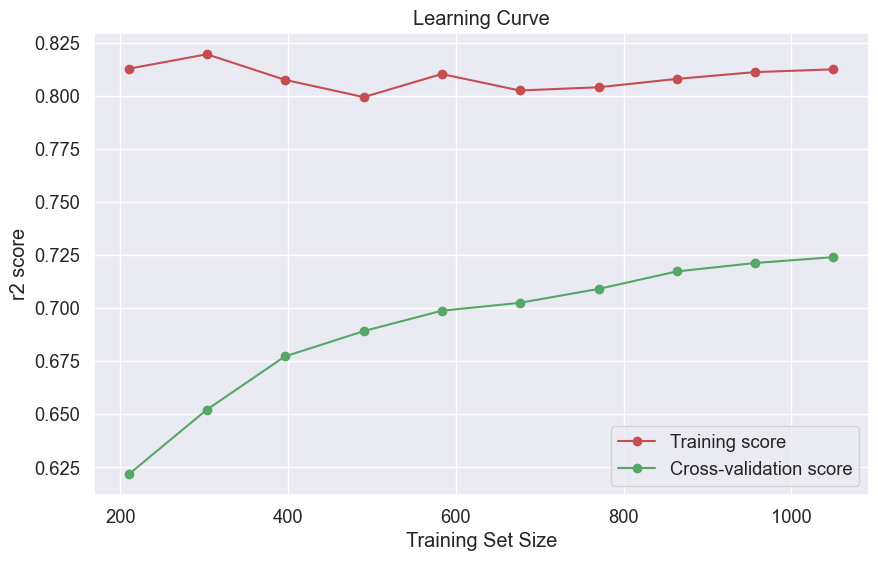

In [43]:
my_learning_curve(best_model_svr, X_train_gas, y_train_gas)

D'après la courbe d'apprentissage, notre modèle a encore besoin de données et présente un léger surajustement.

## <a name="C10"> 2.5 Adaboost </a>
<a href="#top">sommaire</a>

### Adaboost sans Hyperparametre Tuning

In [44]:
model_ada = AdaBoostRegressor(random_state=random_state)
models = [model_ada]
result_model_ada = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_model_ada["model"] = "Adaboost sans tuning"
result_model_ada

Cross val R2 values for model AdaBoostRegressor :  [0.68 0.64 0.71 0.64 0.68]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Adaboost sans tuning,0.72,0.67,0.53,0.76,0.34,0.98,0.088073


### Recursive Feature Elimination (RFE)

Optimal number of features : 9


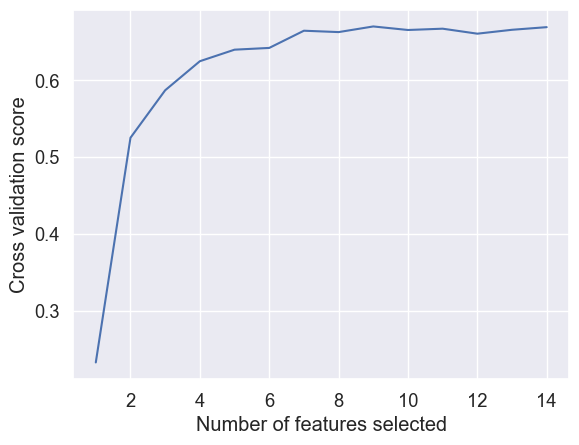

In [45]:
rfe_graph(model_ada, X_train_gas, y_train_gas)

In [46]:
# Select the best features according to RFE
selected_features = rfe_features(model_ada, 9, X_train_gas, y_train_gas)

selected_features: ['PrimaryPropertyType', 'ZipCode', 'BuilgingAge', 'Steam_Use_Rate', 'Natural_Use_Rate', 'LargestPropertyUseType', 'GFA_per_floor', 'GFA_per_building', 'Rate_largest_GFA']


In [47]:
cols_ada = selected_features
models = [model_ada]
result_ada_rfe = train_evaluate_models2(models, X_train_gas[cols_ada], y_train_gas, X_test_gas[cols_ada], y_test_gas)
result_ada_rfe["model"] = "Adaboost RFE"
result_ada_rfe

Cross val R2 values for model AdaBoostRegressor :  [0.66 0.64 0.71 0.65 0.69]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Adaboost RFE,0.73,0.67,0.54,0.75,0.34,0.97,0.076035


## Hyperparametre Tuning Gridsearch pour  Adaboost

In [48]:
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0], 
              'loss': ['linear', 'square', 'exponential']}
model_ada = AdaBoostRegressor(random_state=random_state)# -1
best_ada_model = gridsearch_model(X_train_gas[cols_ada], y_train_gas, model_ada, ada_params)

Best hyperparameters for AdaBoostRegressor(random_state=0) : {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}
Best score for AdaBoostRegressor(random_state=0) : 0.6795750169710555
Gridsearch time:  20.59499502182007 s


In [49]:
models = [best_ada_model]
result_ada_tuning = train_evaluate_models2(models, X_train_gas[cols_ada], y_train_gas, 
                                           X_test_gas[cols_ada], y_test_gas)
result_ada_tuning["model"] = "Adaboost Tuning"
result_ada_tuning

Cross val R2 values for model AdaBoostRegressor :  [0.7  0.66 0.69 0.65 0.69]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Adaboost Tuning,0.74,0.68,0.59,0.71,0.33,0.92,0.235325


In [50]:
compare_ada = pd.concat([result_model_ada, result_ada_rfe, result_ada_tuning], axis=0, ignore_index=True) 
compare_ada

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Adaboost sans tuning,0.72,0.67,0.53,0.76,0.34,0.98,0.088073
1,Adaboost RFE,0.73,0.67,0.54,0.75,0.34,0.97,0.076035
2,Adaboost Tuning,0.74,0.68,0.59,0.71,0.33,0.92,0.235325


,Feature Importance,Feature Name
4,0.234465,Natural_Use_Rate
7,0.226731,GFA_per_building
2,0.169836,BuilgingAge
6,0.085369,GFA_per_floor
5,0.080522,LargestPropertyUseType
0,0.064638,PrimaryPropertyType
3,0.054039,Steam_Use_Rate
1,0.045315,ZipCode
8,0.039084,Rate_largest_GFA


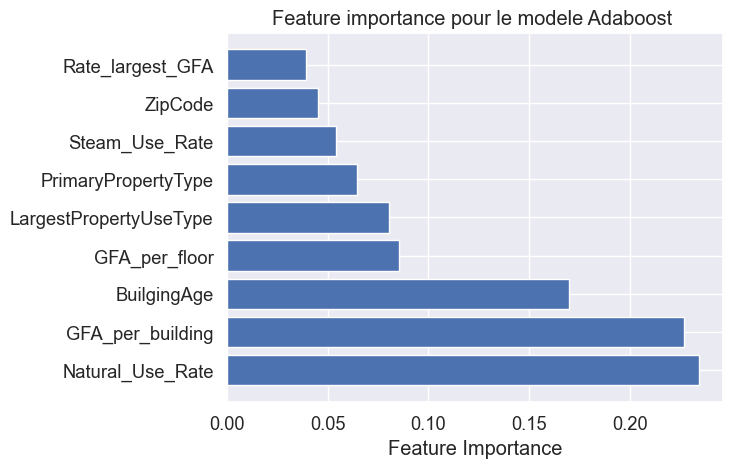

In [51]:
show_feature_importance(best_ada_model,  X_train_gas[cols_ada], "Adaboost")

On constate que les variables le plus importantes pour le modèle sont Natural_Use_Rate, GFA_per_building et BuildingAge

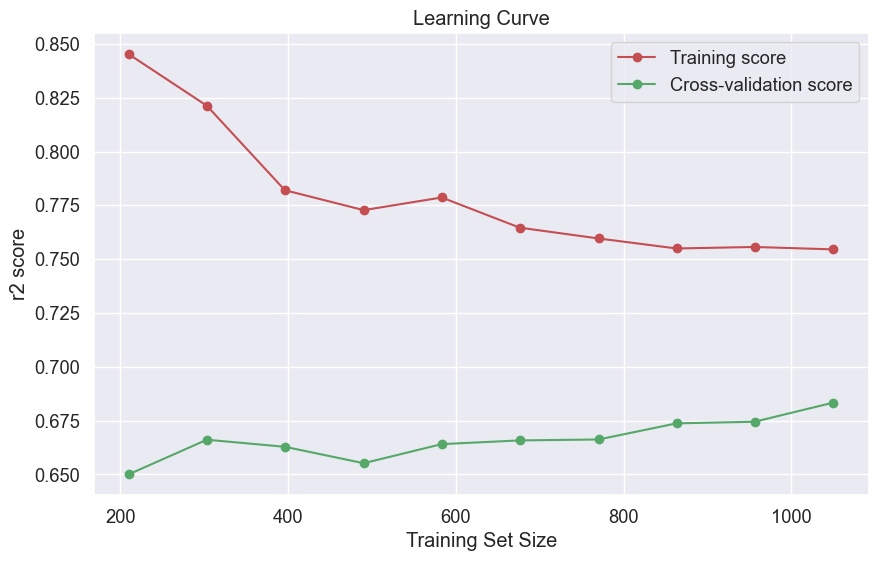

In [52]:
my_learning_curve(best_ada_model, X_train_gas[cols_ada], y_train_gas)

D'après la courbe d'apprentissage, notre modèle a encore besoin de données.

## <a name="C11"> 2.6 Random Forest </a>
<a href="#top">sommaire</a>

### Random Forest sans Hyperparametre Tuning

In [53]:
rf_model = RandomForestRegressor(random_state=random_state)
models = [rf_model]
result_rf_model = train_evaluate_models2(models, X_train_gas, y_train_gas, X_test_gas, y_test_gas)
result_rf_model["model"] = "Random Forest sans tuning"
result_rf_model

Cross val R2 values for model RandomForestRegressor :  [0.77 0.73 0.77 0.75 0.76]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest sans tuning,0.97,0.76,0.69,0.58,0.29,0.79,0.504765


### Recursive Feature Elimination (RFE)

Optimal number of features : 10


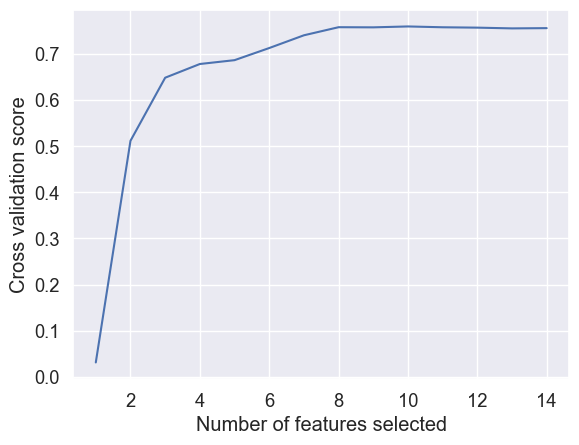

In [54]:
rfe_graph(rf_model, X_train_gas, y_train_gas)

In [55]:
# Select the best features according to RFE
selected_features = rfe_features(rf_model, 8, X_train_gas, y_train_gas)

selected_features: ['PrimaryPropertyType', 'BuilgingAge', 'Steam_Use_Rate', 'Natural_Use_Rate', 'LargestPropertyUseType', 'GFA_per_floor', 'GFA_per_building', 'Rate_largest_GFA']


In [56]:
cols_rf = selected_features
models = [rf_model]
result_rf_rfe = train_evaluate_models2(models, X_train_gas[cols_rf], y_train_gas, X_test_gas[cols_rf], y_test_gas)
result_rf_rfe["model"] = "Random Forest RFE"
result_rf_rfe

Cross val R2 values for model RandomForestRegressor :  [0.77 0.74 0.76 0.76 0.76]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest RFE,0.97,0.76,0.71,0.57,0.27,0.78,0.368016


## Hyperparametre Tuning Gridsearch pour  Random Forest

In [57]:
rf_params = {'n_estimators': [75,100, 150], 'max_depth': [3,4,5,6], 'bootstrap' : [True, False],
             'max_features' : [0.4,0.5, 0.6, 0.7, 0.8], 'min_samples_leaf': [2, 4,6, 8]}
rf_model = RandomForestRegressor(random_state=0, n_jobs=-1)# -1
best_rf_model = gridsearch_model(X_train_gas[cols_rf], y_train_gas, rf_model, rf_params)

Best hyperparameters for RandomForestRegressor(n_jobs=-1, random_state=0) : {'bootstrap': True, 'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 2, 'n_estimators': 150}
Best score for RandomForestRegressor(n_jobs=-1, random_state=0) : 0.7436374287109355
Gridsearch time:  191.02342295646667 s


In [58]:
models = [best_rf_model]
result_rf_tuning = train_evaluate_models2(models, X_train_gas[cols_rf], y_train_gas, X_test_gas[cols_rf], y_test_gas)
result_rf_tuning["model"] = "Random Forest Tuning"
result_rf_tuning

Cross val R2 values for model RandomForestRegressor :  [0.76 0.74 0.74 0.73 0.74]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest Tuning,0.84,0.74,0.68,0.61,0.29,0.81,0.219217


In [59]:
compare_rf = pd.concat([result_rf_model, result_rf_rfe, result_rf_tuning], axis=0, ignore_index=True) 
compare_rf

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest sans tuning,0.97,0.76,0.69,0.58,0.29,0.79,0.504765
1,Random Forest RFE,0.97,0.76,0.71,0.57,0.27,0.78,0.368016
2,Random Forest Tuning,0.84,0.74,0.68,0.61,0.29,0.81,0.219217


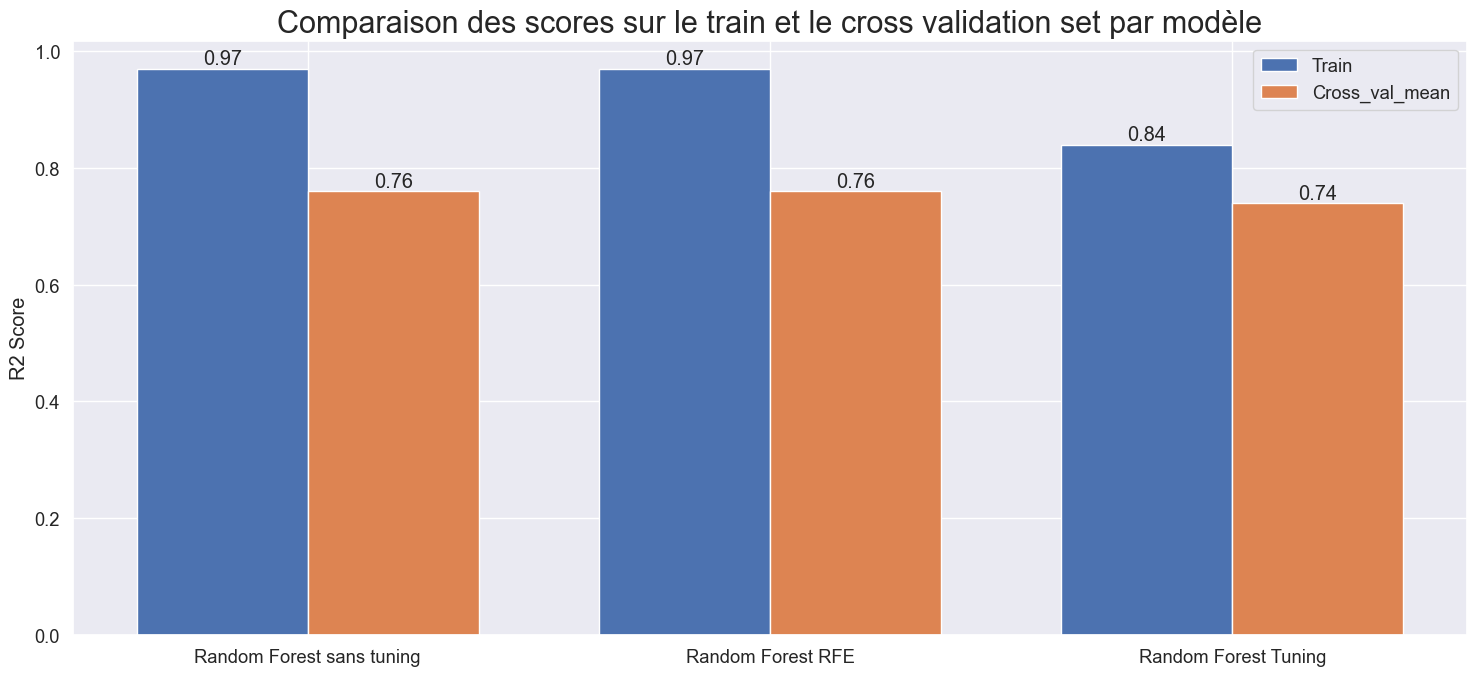

In [60]:
plot_scores(compare_rf)

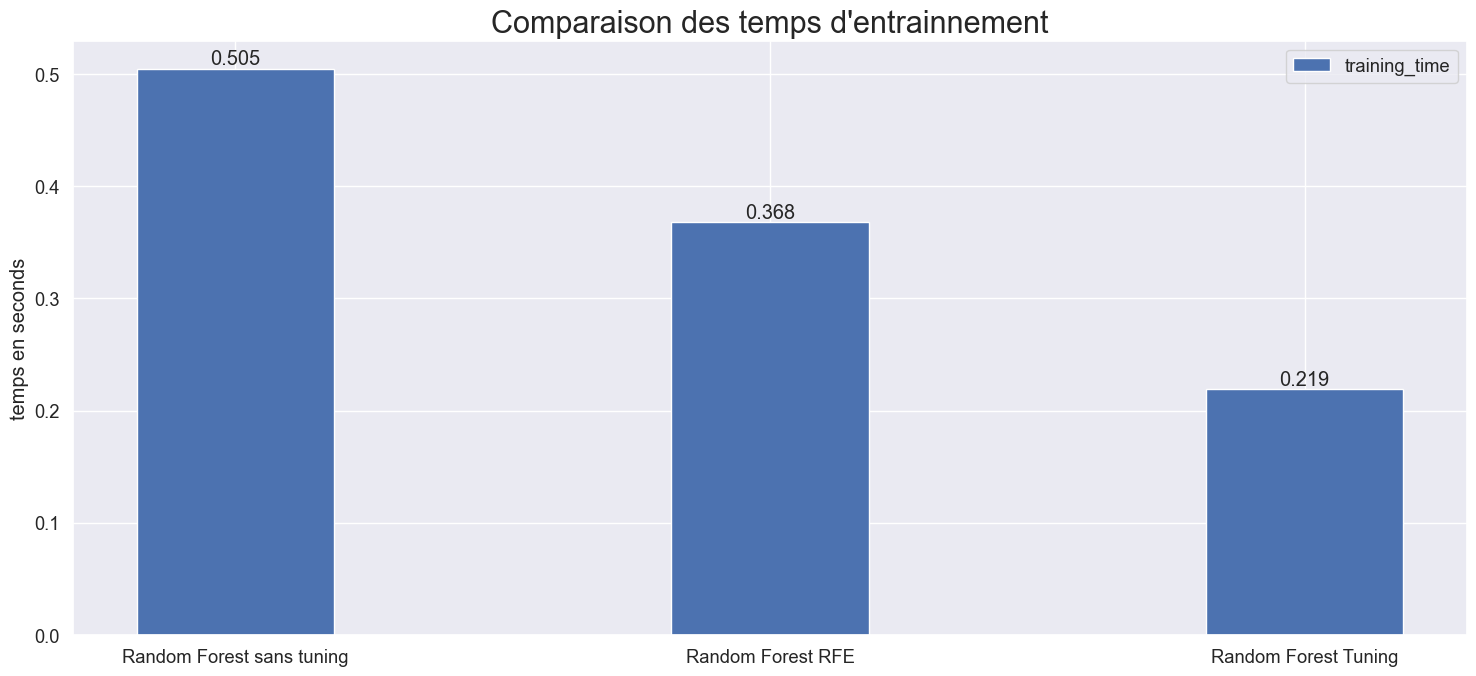

In [61]:
plot_training_times(compare_rf)

On constate que les démarches RFE (Recursive Feature Elimination) et GridSearch améliorent la performance du modèle en réduisant l’overfitting et le temps d'entraînement.

,Feature Importance,Feature Name
6,0.350202,GFA_per_building
3,0.290427,Natural_Use_Rate
0,0.124643,PrimaryPropertyType
4,0.122858,LargestPropertyUseType
2,0.042233,Steam_Use_Rate
5,0.039115,GFA_per_floor
1,0.015909,BuilgingAge
7,0.014612,Rate_largest_GFA


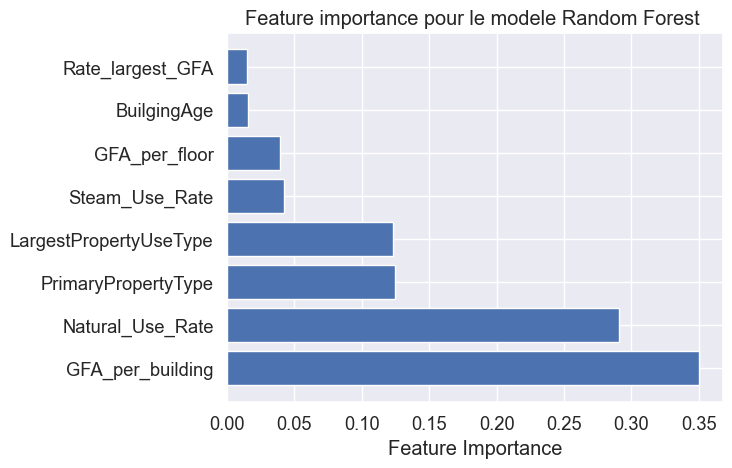

In [62]:
show_feature_importance(best_rf_model,  X_train_gas[cols_rf], "Random Forest")

On constate que les variables le plus importantes pour le modèle sont Natural_Use_Rate, GFA_per_building

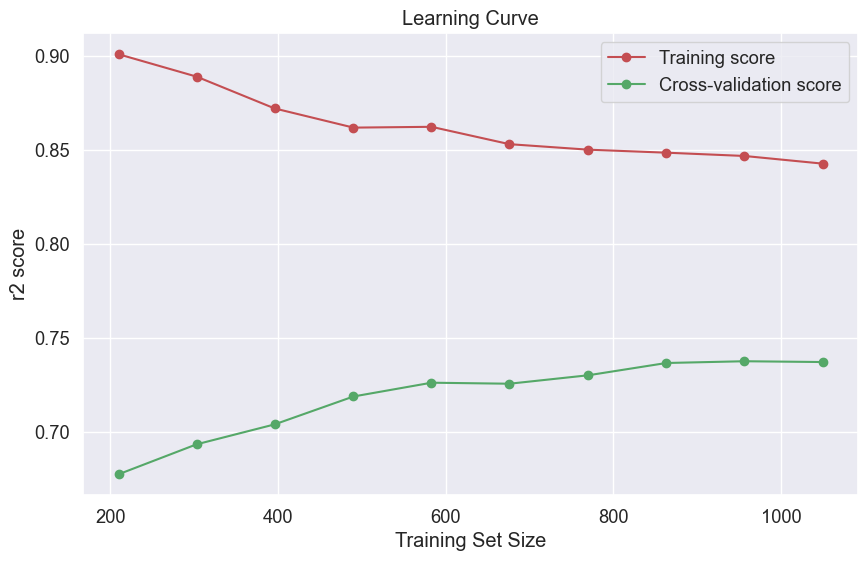

In [63]:
my_learning_curve(best_rf_model, X_train_gas[cols_rf], y_train_gas)

D'après la courbe d'apprentissage, notre modèle a encore besoin de données et présente un léger surajustement.

### Comparaison des valeurs réelles et des prédictions en logarithme.

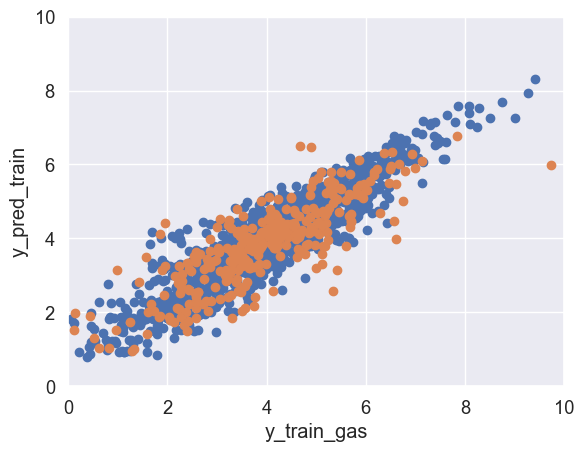

In [64]:
best_rf_model.fit(X_train_gas[cols_rf], y_train_gas)
train_preds = best_rf_model.predict(X_train_gas[cols_rf])
test_preds = best_rf_model.predict(X_test_gas[cols_rf])
plt.scatter(y_train_gas, train_preds )
plt.scatter(y_test_gas, test_preds)
plt.xlabel("y_train_gas")
plt.ylabel("y_pred_train")
plt.xlim([0.0,10])
plt.ylim([0.0,10]);

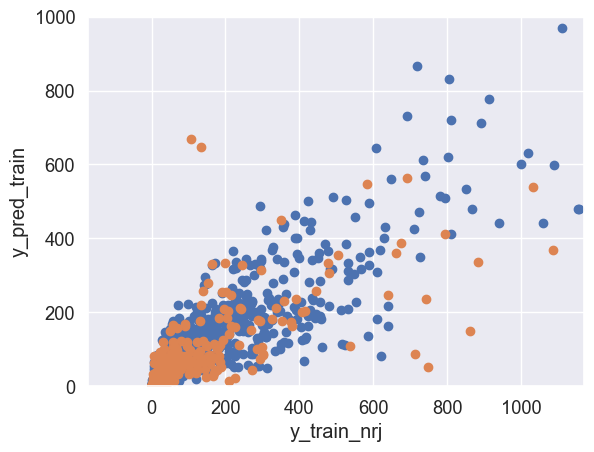

In [65]:
best_rf_model.fit(X_train_gas[cols_rf], y_train_gas)
train_preds = best_rf_model.predict(X_train_gas[cols_rf])
test_preds = best_rf_model.predict(X_test_gas[cols_rf])
plt.scatter(np.exp(y_train_gas), np.exp(train_preds))
plt.scatter(np.exp(y_test_gas), np.exp(test_preds))
plt.xlabel("y_train_nrj")
plt.ylabel("y_pred_train")
plt.axis('equal')
plt.xlim([0.0,1*1e3])
plt.ylim([0.0,1*1e3]);

Lors de la conversion des valeurs en logarithmique et en les retransformant en échelle exponentielle, nous avons obtenu des résultats légèrement moins bons.


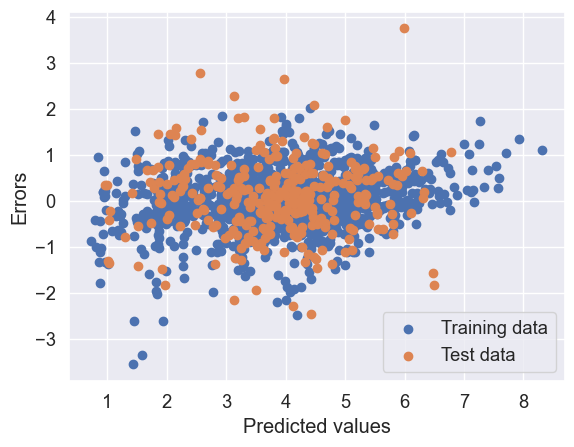

In [66]:
# Make predictions on training and test data
best_rf_model.fit(X_train_gas[cols_rf], y_train_gas)
train_preds = best_rf_model.predict(X_train_gas[cols_rf])
test_preds = best_rf_model.predict(X_test_gas[cols_rf])
# Calculate errors for training and test data
train_errors = y_train_gas - train_preds
test_errors = y_test_gas - test_preds

plt.scatter(train_preds, train_errors, label='Training data')
plt.scatter(test_preds, test_errors, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Errors')
plt.legend()
plt.show()

Les erreurs sont plutôt proches de zéro.

## <a name="C12"> 2.7 Comparaison des résultats pour la consommation d'énergie </a>
<a href="#top">sommaire</a>

In [67]:
compare_gas = pd.concat([result_lr_rfe, result_lcv, result_svr_tuning, result_rf_tuning, result_ada_tuning],
                        axis=0, ignore_index=True) 
compare_gas.sort_values("cv_mean", ascending=False)

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
3,Random Forest Tuning,0.84,0.74,0.68,0.61,0.29,0.81,0.219217
2,SVR Tuning,0.81,0.72,0.72,0.55,0.28,0.76,0.105190
4,Adaboost Tuning,0.74,0.68,0.59,0.71,0.33,0.92,0.235325
0,LinearRegression RFE,0.64,0.62,0.61,0.69,0.38,0.89,0.002332
1,LassoCV,0.64,0.61,0.61,0.69,0.38,0.89,0.027860


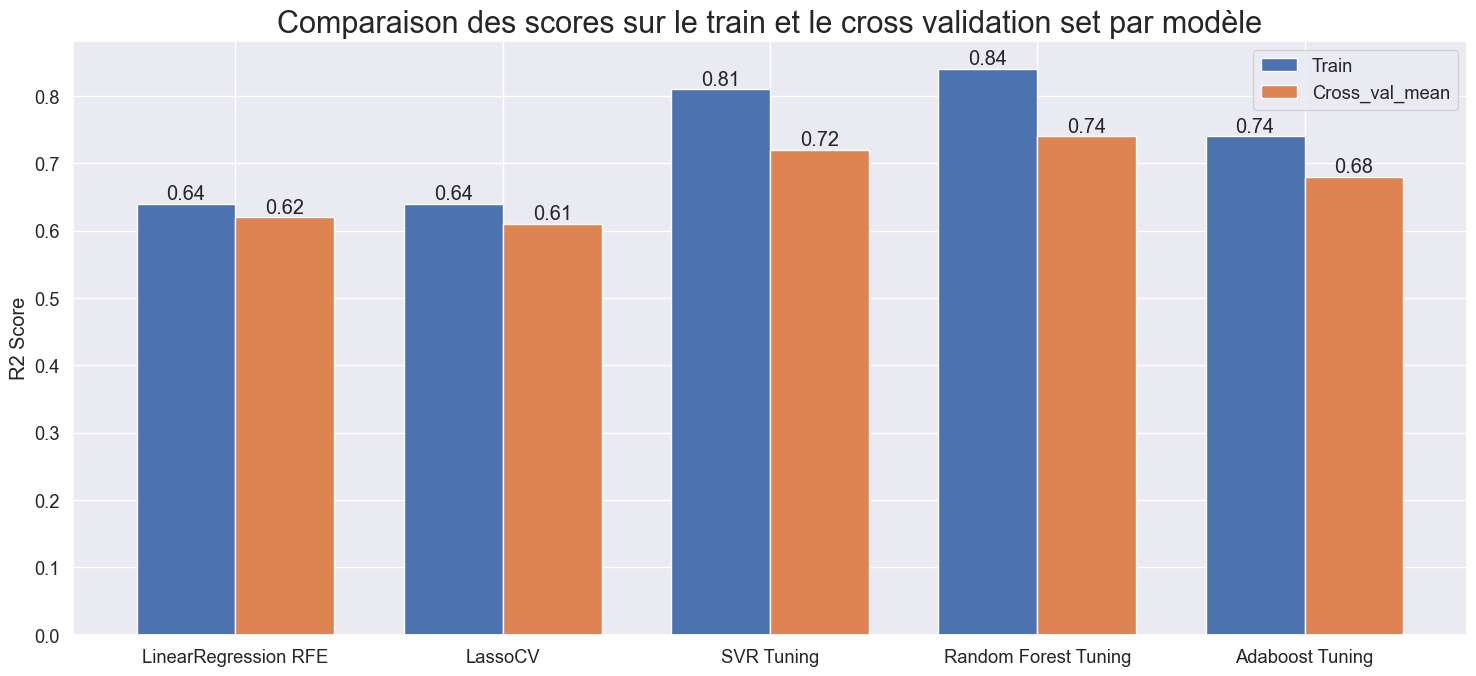

In [68]:
plot_scores(compare_gas)

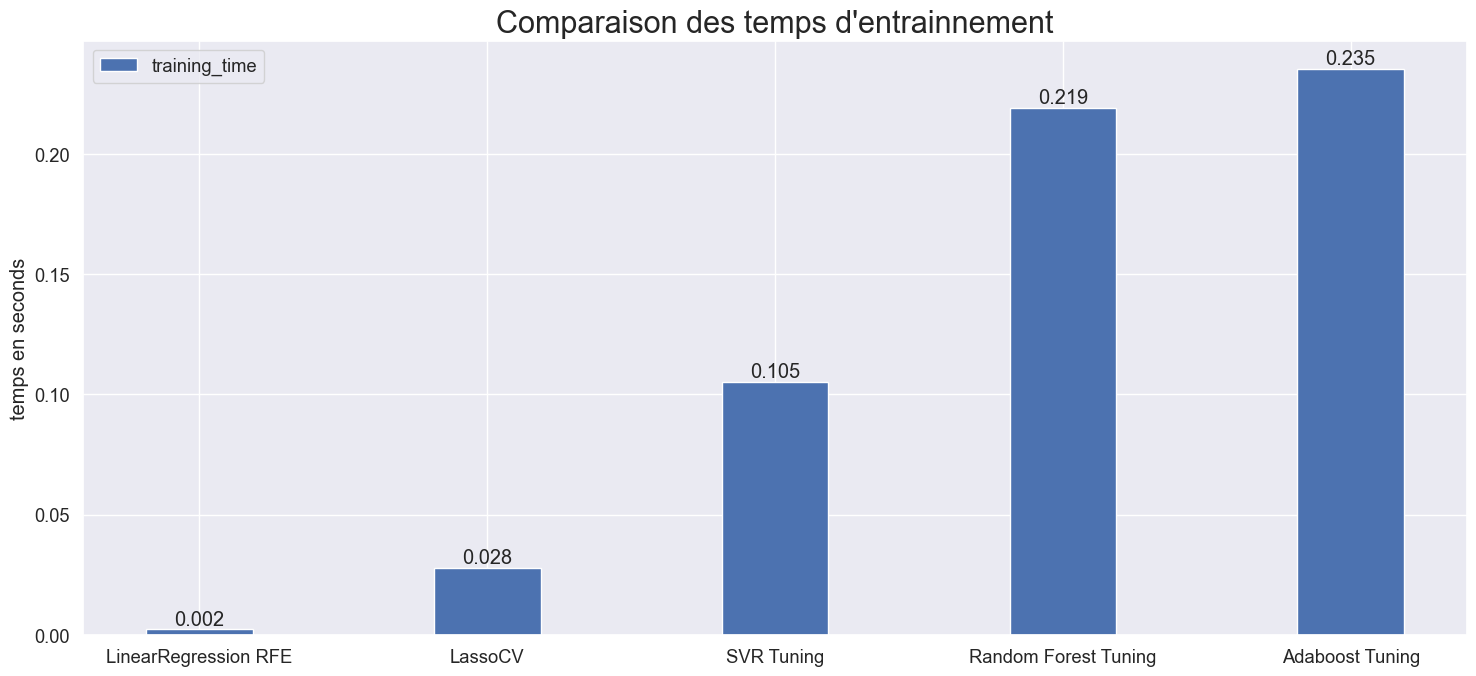

In [69]:
plot_training_times(compare_gas)

On a choisi le modèle Random Forest en fonction de sa performance R2 et de son temps d'entraînement.


# <a name="C5"> Les Analyses pour Energy Star Score </a>
<a href="#top">sommaire</a>

In [70]:
print(data_analyse_both.shape)
data_analyse_both.head(2)

(1642, 17)


,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,Steam_Use_Rate,SiteEnergyUseWN(kBtu),Natural_Use_Rate,TotalGHGEmissions,ENERGYSTARScore,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,NonResidential,Hotel,98101,96,26.87282,7456910.0,17.11772,249.98,60.0,7,DOWNTOWN,Hotel,2627.000084,0.000000,7369.500000,88434.0,1.000000
1,NonResidential,Hotel,98101,27,0.00000,8664479.0,59.38132,295.86,61.0,7,DOWNTOWN,Hotel,2582.229311,14.545314,9415.090909,103566.0,0.809918


### On va supprimer les valeurs nulles pour la variable ENERGYSTARScore et continuer avec un dataframe plus petit

In [71]:
# On va supprimer les nulls pour ENERGYSTARScore
data_for_star = data_analyse_both.dropna()
print(data_for_star.shape)
data_for_star.isnull().sum()

(1087, 17)


BuildingType              0
PrimaryPropertyType       0
ZipCode                   0
BuilgingAge               0
Steam_Use_Rate            0
SiteEnergyUseWN(kBtu)     0
Natural_Use_Rate          0
TotalGHGEmissions         0
ENERGYSTARScore           0
CouncilDistrictCode       0
Neighborhood              0
LargestPropertyUseType    0
Distance_center_feet      0
Parking_rate              0
GFA_per_floor             0
GFA_per_building          0
Rate_largest_GFA          0
dtype: int64

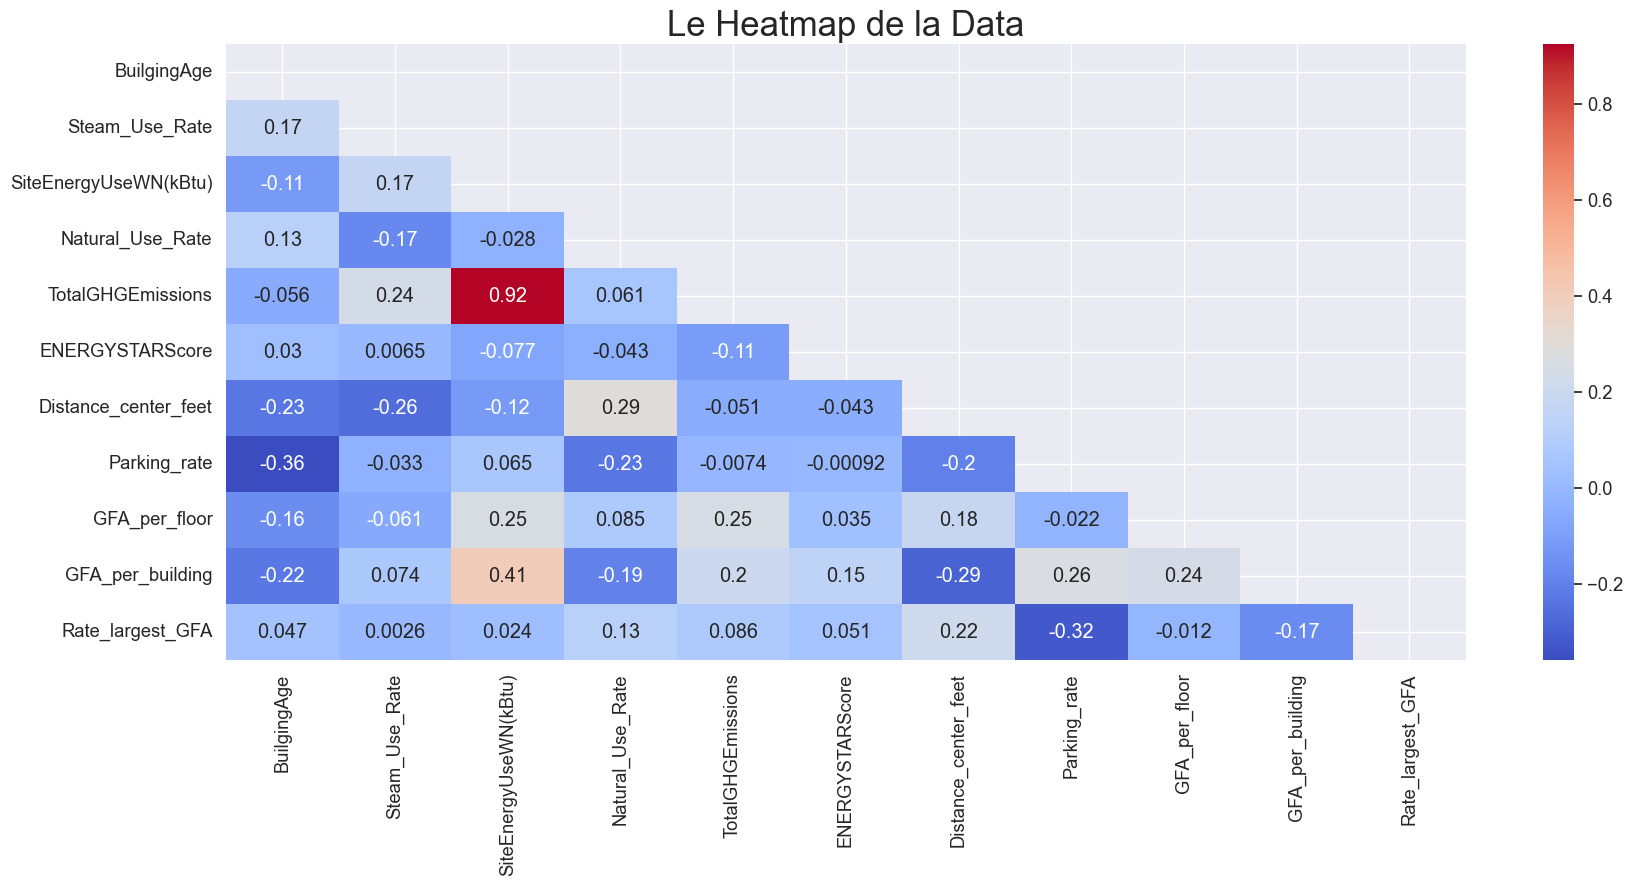

In [72]:
heatmap(data_for_star)

## <a name="C13"> 3.1 Les Analyses Sans Energy Star Score </a>
<a href="#top">sommaire</a>

In [73]:
data_no_star_gas = data_for_star.drop(["SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis=1)

In [74]:
X_no_star = data_no_star_gas.drop("TotalGHGEmissions", axis=1)
y_no_star = data_no_star_gas["TotalGHGEmissions"]
y_no_star = np.log(y_no_star)

In [75]:
# Split the data into training and test sets
X_train_no_star, X_test_no_star, y_train_no_star, y_test_no_star = train_test_split(X_no_star, y_no_star, 
                                                                        test_size=0.2, random_state=0)

In [76]:
categorical = X_train_no_star.select_dtypes(include = "O").columns.tolist()
numerical = X_train_no_star.select_dtypes(exclude = "O").columns.tolist()

In [77]:
#scaler = RobustScaler()
encoder = TargetEncoder()
scaler =  StandardScaler()

X_train_no_star[categorical] = encoder.fit_transform(X_train_no_star[categorical], y_train_no_star)
X_test_no_star[categorical] = encoder.transform(X_test_no_star[categorical], y_test_no_star)

X_train_no_star = scaler.fit_transform(X_train_no_star)
X_test_no_star = scaler.transform(X_test_no_star)
X_train_no_star = pd.DataFrame(X_train_no_star, columns=X_no_star.columns)
X_test_no_star = pd.DataFrame(X_test_no_star, columns=X_no_star.columns)

In [78]:
print(X_train_no_star.shape)
X_train_no_star.head(2)

(869, 14)


,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,Steam_Use_Rate,Natural_Use_Rate,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,-0.306682,-0.898447,-0.200489,-0.318607,-0.240072,-1.021065,1.184228,-0.284139,0.064024,-0.524702,1.184661,-0.433723,-0.194835,-0.509605
1,2.502353,-1.234985,-1.416547,-0.664419,-0.240072,0.716288,-1.297364,-1.370177,-1.598927,-0.524795,-0.495895,-0.303537,-0.530477,-0.157084


## <a name="C14"> 3.1.1 Linear Regression et les autres modèles Baseline et Cross validation </a>
<a href="#top">sommaire</a>

In [79]:
# Train and evaluate the models on the data
random_state = 0
models = [DummyRegressor(strategy="mean"),
          LinearRegression(),
          Lasso(),
          SVR(),
          RandomForestRegressor(random_state=random_state),
          AdaBoostRegressor(random_state=random_state)]
  # list of models to train and evaluate
results = train_evaluate_models2(models, X_train_no_star, y_train_no_star, X_test_no_star, y_test_no_star)

# Display the results for comparison
display(results)

Cross val R2 values for model DummyRegressor :  [-0.   -0.   -0.01 -0.   -0.01]
Cross val R2 values for model LinearRegression :  [0.71 0.7  0.75 0.69 0.68]
Cross val R2 values for model Lasso :  [-0.   -0.   -0.01 -0.   -0.01]
Cross val R2 values for model SVR :  [0.77 0.79 0.71 0.75 0.72]
Cross val R2 values for model RandomForestRegressor :  [0.75 0.81 0.83 0.8  0.75]
Cross val R2 values for model AdaBoostRegressor :  [0.68 0.73 0.69 0.71 0.7 ]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,DummyRegressor,0.00,-0.00,-0.03,1.20,0.55,1.51,0.000223
1,LinearRegression,0.72,0.71,0.72,0.62,0.25,0.79,0.004110
2,Lasso,0.00,-0.00,-0.03,1.20,0.55,1.51,0.000762
3,SVR,0.82,0.75,0.78,0.54,0.21,0.69,0.044731
4,RandomForestRegressor,0.97,0.79,0.80,0.51,0.18,0.67,0.336863
5,AdaBoostRegressor,0.78,0.70,0.69,0.65,0.23,0.82,0.072638


## Lineer Regression

In [80]:
model_lr = LinearRegression()
models = [model_lr]
result_lr_base_no_star = train_evaluate_models2(models, X_train_no_star, y_train_no_star, X_test_no_star,
                                                y_test_no_star)
result_lr_base_no_star["model"] = "LinearRegression base No Star"
result_lr_base_no_star

Cross val R2 values for model LinearRegression :  [0.71 0.7  0.75 0.69 0.68]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression base No Star,0.72,0.71,0.72,0.62,0.25,0.79,0.002509


### Recursive Feature Elimination (RFE)

Optimal number of features : 13


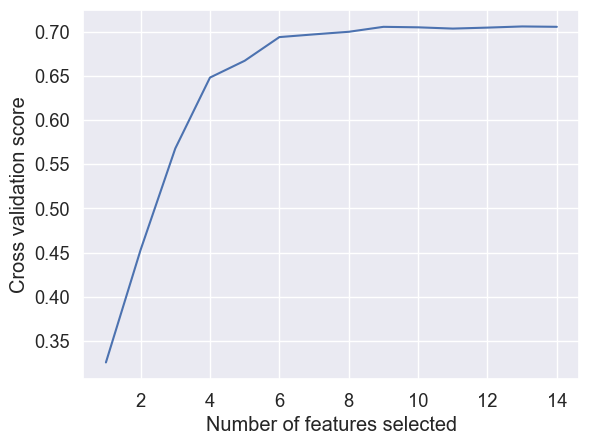

In [81]:
rfe_graph(model_lr, X_train_no_star, y_train_no_star)

In [82]:
# Select the best features according to RFE
selected_features = rfe_features(model_lr, 9, X_train_no_star, y_train_no_star)

selected_features: ['PrimaryPropertyType', 'ZipCode', 'BuilgingAge', 'Steam_Use_Rate', 'Natural_Use_Rate', 'LargestPropertyUseType', 'Distance_center_feet', 'GFA_per_floor', 'GFA_per_building']


In [83]:
cols_lr = selected_features
models = [model_lr]
result_lr_rfe_no_star = train_evaluate_models2(models, X_train_no_star[cols_lr],
                                            y_train_no_star, X_test_no_star[cols_lr], y_test_no_star)
result_lr_rfe_no_star["model"] = "LinearRegression RFE No Star"
result_lr_rfe_no_star

Cross val R2 values for model LinearRegression :  [0.7  0.7  0.75 0.69 0.68]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE No Star,0.72,0.71,0.72,0.63,0.25,0.79,0.003012


## <a name="C15"> 3.1.2 Random Forest </a>
<a href="#top">sommaire</a>

### Random Forest sans Hyperparametre Tuning

In [84]:
rf_model = RandomForestRegressor(random_state=random_state)
models = [rf_model]
result_rf_model_no_star = train_evaluate_models2(models, X_train_no_star, y_train_no_star, X_test_no_star,
                                                 y_test_no_star)
result_rf_model_no_star["model"] = "Random Forest No Star sans tuning"
result_rf_model_no_star

Cross val R2 values for model RandomForestRegressor :  [0.75 0.81 0.83 0.8  0.75]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest No Star sans tuning,0.97,0.79,0.8,0.51,0.18,0.67,0.343581


### Recursive Feature Elimination (RFE)

Optimal number of features : 7


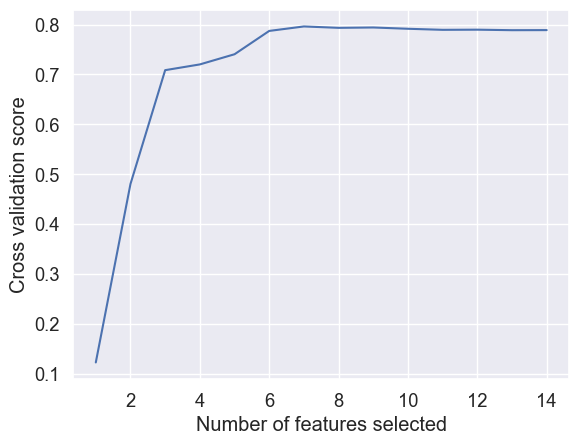

In [85]:
rfe_graph(rf_model, X_train_no_star, y_train_no_star)

In [86]:
# Select the best features according to RFE
selected_features = rfe_features(rf_model, 7, X_train_no_star, y_train_no_star)

selected_features: ['PrimaryPropertyType', 'Steam_Use_Rate', 'Natural_Use_Rate', 'LargestPropertyUseType', 'GFA_per_floor', 'GFA_per_building', 'Rate_largest_GFA']


In [87]:
cols_rf = selected_features
models = [rf_model]
result_rf_rfe_no_star = train_evaluate_models2(models, X_train_no_star[cols_rf], y_train_no_star,
                                               X_test_no_star[cols_rf], y_test_no_star)
result_rf_rfe_no_star["model"] = "Random Forest No Star RFE"
result_rf_rfe_no_star

Cross val R2 values for model RandomForestRegressor :  [0.76 0.81 0.84 0.8  0.77]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest No Star RFE,0.97,0.8,0.79,0.51,0.17,0.68,0.216261


## Hyperparametre Tuning Gridsearch pour  Random Forest

In [88]:
rf_params = {'n_estimators': [50,75,100], 'max_depth': [3,4,5,6], 'bootstrap' : [True, False],
             'max_features' : [0.4,0.5, 0.6, 0.7, 0.8], 'min_samples_leaf': [2, 4,6, 8]}
rf_model = RandomForestRegressor(random_state=0, n_jobs=-1)# -1
best_rf_model = gridsearch_model(X_train_no_star[cols_rf], y_train_no_star, rf_model, rf_params)

Best hyperparameters for RandomForestRegressor(n_jobs=-1, random_state=0) : {'bootstrap': True, 'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 2, 'n_estimators': 100}
Best score for RandomForestRegressor(n_jobs=-1, random_state=0) : 0.7861699960171229
Gridsearch time:  122.31866002082825 s


In [89]:
models = [best_rf_model]
result_rf_tuning_no_star = train_evaluate_models2(models, X_train_no_star[cols_rf], 
                                                  y_train_no_star, X_test_no_star[cols_rf],
                                               y_test_no_star)
result_rf_tuning_no_star["model"] = "Random Forest No Star Tuning"
result_rf_tuning_no_star

Cross val R2 values for model RandomForestRegressor :  [0.77 0.81 0.82 0.78 0.75]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest No Star Tuning,0.88,0.79,0.79,0.52,0.19,0.69,0.108291


### Comparaison de l'émission de gaz sans Energy Star Score

In [90]:
compare_nrj_no_star = pd.concat([result_lr_rfe_no_star, result_rf_tuning_no_star], axis=0) 
compare_nrj_no_star

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE No Star,0.72,0.71,0.72,0.63,0.25,0.79,0.003012
0,Random Forest No Star Tuning,0.88,0.79,0.79,0.52,0.19,0.69,0.108291


## <a name="C16"> 3.2 Les Analyses Avec Energy Star Score </a>
<a href="#top">sommaire</a>

In [91]:
data_star_nrj = data_for_star.drop("TotalGHGEmissions", axis=1)

In [92]:
X_star = data_star_nrj.drop("SiteEnergyUseWN(kBtu)", axis=1)
y_star = data_star_nrj["SiteEnergyUseWN(kBtu)"]

In [93]:
y_star = np.log(y_star)

In [94]:
# Split the data into training and test sets
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_star, test_size=0.2, random_state=0)

In [95]:
categorical = X_train_star.select_dtypes(include = "O").columns.tolist()
numerical = X_train_star.select_dtypes(exclude = "O").columns.tolist()

In [96]:
categorical

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType']

In [97]:
numerical

['BuilgingAge',
 'Steam_Use_Rate',
 'Natural_Use_Rate',
 'ENERGYSTARScore',
 'Distance_center_feet',
 'Parking_rate',
 'GFA_per_floor',
 'GFA_per_building',
 'Rate_largest_GFA']

In [98]:
#scaler = RobustScaler()
encoder = TargetEncoder()
scaler =  StandardScaler()

X_train_star[categorical] = encoder.fit_transform(X_train_star[categorical], y_train_star)
X_test_star[categorical] = encoder.transform(X_test_star[categorical], y_test_star)

X_train_star = scaler.fit_transform(X_train_star)
X_test_star = scaler.transform(X_test_star)
X_train_star = pd.DataFrame(X_train_star, columns=X_star.columns)
X_test_star = pd.DataFrame(X_test_star, columns=X_star.columns)

In [99]:
print(X_train_star.shape)
X_train_star.head(2)

(869, 15)


,BuildingType,PrimaryPropertyType,ZipCode,BuilgingAge,Steam_Use_Rate,Natural_Use_Rate,ENERGYSTARScore,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,Distance_center_feet,Parking_rate,GFA_per_floor,GFA_per_building,Rate_largest_GFA
0,0.141682,-0.579109,-0.078802,-0.318607,-0.240072,-1.021065,0.523299,1.292857,-0.151507,0.587744,-0.524702,1.184661,-0.433723,-0.194835,-0.509605
1,4.627523,-1.210821,-1.355350,-0.664419,-0.240072,0.716288,0.452394,-1.158688,-1.319920,-1.644930,-0.524795,-0.495895,-0.303537,-0.530477,-0.157084


## <a name="C17"> 3.2.1 Linear Regression et les autres modèles Baseline et Cross validation </a>
<a href="#top">sommaire</a>

In [100]:
# Train and evaluate the models on the data
random_state = 0
models = [DummyRegressor(strategy="mean"),
          LinearRegression(),
          Lasso(), 
          SVR(),
          RandomForestRegressor(random_state=random_state),
          AdaBoostRegressor(random_state=random_state)]
  # list of models to train and evaluate
results = train_evaluate_models2(models, X_train_star, y_train_star, X_test_star, y_test_star)

# Display the results for comparison
display(results)

Cross val R2 values for model DummyRegressor :  [-0.   -0.   -0.   -0.   -0.01]
Cross val R2 values for model LinearRegression :  [0.72 0.74 0.75 0.7  0.75]
Cross val R2 values for model Lasso :  [-0.   -0.   -0.   -0.   -0.01]
Cross val R2 values for model SVR :  [0.78 0.82 0.73 0.76 0.74]
Cross val R2 values for model RandomForestRegressor :  [0.76 0.84 0.85 0.83 0.84]
Cross val R2 values for model AdaBoostRegressor :  [0.73 0.79 0.73 0.76 0.74]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,DummyRegressor,0.00,-0.00,-0.04,1.01,0.07,1.24,0.000208
1,LinearRegression,0.75,0.73,0.73,0.47,0.03,0.62,0.001590
2,Lasso,0.00,-0.00,-0.04,1.01,0.07,1.24,0.000650
3,SVR,0.85,0.77,0.81,0.41,0.03,0.53,0.044172
4,RandomForestRegressor,0.98,0.83,0.86,0.35,0.02,0.46,0.369535
5,AdaBoostRegressor,0.83,0.75,0.75,0.48,0.03,0.60,0.071179


## Lineer Regression

In [101]:
model_lr = LinearRegression()
models = [model_lr]
result_lr_base_star = train_evaluate_models2(models, X_train_star, y_train_star, X_test_star, y_test_star)
result_lr_base_star["model"] = "LinearRegression base Star"
result_lr_base_star

Cross val R2 values for model LinearRegression :  [0.72 0.74 0.75 0.7  0.75]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression base Star,0.75,0.73,0.73,0.47,0.03,0.62,0.002238


### Recursive Feature Elimination (RFE)

Optimal number of features : 12


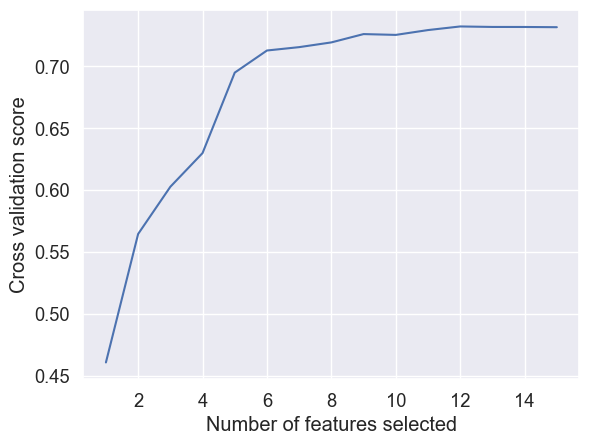

In [102]:
rfe_graph(model_lr, X_train_star, y_train_star)

In [103]:
# Select the best features according to RFE
selected_features = rfe_features(model_lr, 12, X_train_star, y_train_star)

selected_features: ['PrimaryPropertyType', 'ZipCode', 'BuilgingAge', 'Steam_Use_Rate', 'Natural_Use_Rate', 'ENERGYSTARScore', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 'GFA_per_floor', 'GFA_per_building', 'Rate_largest_GFA']


In [104]:
cols_lr = selected_features
models = [model_lr]
result_lr_rfe_star = train_evaluate_models2(models, X_train_star[cols_lr],
                                            y_train_star, X_test_star[cols_lr], y_test_star)
result_lr_rfe_star["model"] = "LinearRegression RFE Star"
result_lr_rfe_star

Cross val R2 values for model LinearRegression :  [0.73 0.74 0.75 0.69 0.75]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE Star,0.75,0.73,0.73,0.47,0.03,0.63,0.002372


## <a name="C18"> 3.2.2 Random Forest </a>
<a href="#top">sommaire</a>

### Random Forest sans Hyperparametre Tuning

In [105]:
rf_model = RandomForestRegressor(random_state=random_state)
models = [rf_model]
result_rf_model_star = train_evaluate_models2(models, X_train_star, y_train_star, X_test_star, y_test_star)
result_rf_model_star["model"] = "Random Forest Star sans tuning"
result_rf_model_star

Cross val R2 values for model RandomForestRegressor :  [0.76 0.84 0.85 0.83 0.84]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest Star sans tuning,0.98,0.83,0.86,0.35,0.02,0.46,0.370587


### Recursive Feature Elimination (RFE)

Optimal number of features : 7


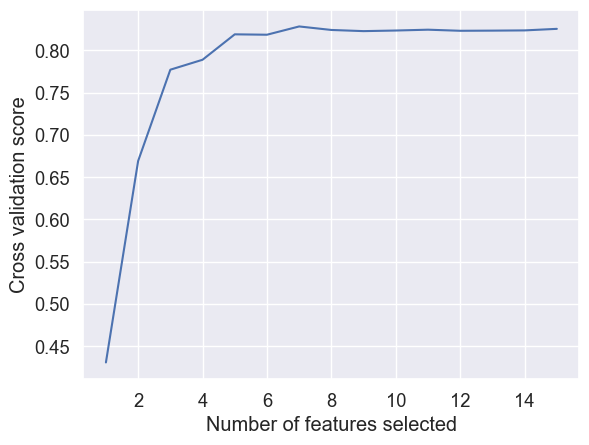

In [106]:
rfe_graph(rf_model, X_train_star, y_train_star)

In [107]:
# Select the best features according to RFE
selected_features = rfe_features(rf_model, 7, X_train_star, y_train_star)

selected_features: ['PrimaryPropertyType', 'Natural_Use_Rate', 'ENERGYSTARScore', 'LargestPropertyUseType', 'GFA_per_floor', 'GFA_per_building', 'Rate_largest_GFA']


In [108]:
cols_rf = selected_features
models = [rf_model]
result_rf_rfe_star = train_evaluate_models2(models, X_train_star[cols_rf], y_train_star, X_test_star[cols_rf],
                                            y_test_star)
result_rf_rfe_star["model"] = "Random Forest Star RFE"
result_rf_rfe_star

Cross val R2 values for model RandomForestRegressor :  [0.76 0.84 0.86 0.83 0.85]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest Star RFE,0.98,0.83,0.86,0.34,0.02,0.45,0.243594


## Hyperparametre Tuning Gridsearch pour  Random Forest

In [109]:
rf_params = {'n_estimators': [50,75,100], 'max_depth': [3,4,5,6], 'bootstrap' : [True, False],
             'max_features' : [0.4,0.5, 0.6, 0.7, 0.8], 'min_samples_leaf': [2, 4,6, 8]}
rf_model = RandomForestRegressor(random_state=0, n_jobs=-1)# -1
best_rf_model = gridsearch_model(X_train_star[cols_rf], y_train_star, rf_model, rf_params)

Best hyperparameters for RandomForestRegressor(n_jobs=-1, random_state=0) : {'bootstrap': True, 'max_depth': 6, 'max_features': 0.6, 'min_samples_leaf': 2, 'n_estimators': 100}
Best score for RandomForestRegressor(n_jobs=-1, random_state=0) : 0.8152522517830256
Gridsearch time:  95.27078795433044 s


In [110]:
models = [best_rf_model]
result_rf_tuning_star = train_evaluate_models2(models, X_train_star[cols_rf], y_train_star, X_test_star[cols_rf],
                                               y_test_star)
result_rf_tuning_star["model"] = "Random Forest Star Tuning"
result_rf_tuning_star

Cross val R2 values for model RandomForestRegressor :  [0.78 0.84 0.84 0.81 0.81]


,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,Random Forest Star Tuning,0.9,0.82,0.82,0.38,0.03,0.51,0.094842


### Comparaison de l'émission de gaz sans Energy Star Score

In [111]:
compare_gas_no_star = pd.concat([result_lr_rfe_no_star, result_rf_tuning_no_star], axis=0, ignore_index=True) 
compare_gas_no_star

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE No Star,0.72,0.71,0.72,0.63,0.25,0.79,0.003012
1,Random Forest No Star Tuning,0.88,0.79,0.79,0.52,0.19,0.69,0.108291


### Comparaison de l'émission de gaz avec Energy Star Score

In [112]:
compare_gas_star = pd.concat([result_lr_rfe_star, result_rf_tuning_star], axis=0, ignore_index=True) 
compare_gas_star

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE Star,0.75,0.73,0.73,0.47,0.03,0.63,0.002372
1,Random Forest Star Tuning,0.90,0.82,0.82,0.38,0.03,0.51,0.094842


# <a name="C19"> 3.3 Comparaison final de la consommation sans et avec Energy Star Score </a>
<a href="#top">sommaire</a>

In [113]:
compare_fin_gas_star = pd.concat([compare_gas_no_star, compare_gas_star], axis=0, ignore_index=True) 
compare_fin_gas_star.sort_values("cv_mean")

,model,r2_train,cv_mean,r2_test,mean_absolute_error,mean_absolute_percentage_error,RMSE,training_time
0,LinearRegression RFE No Star,0.72,0.71,0.72,0.63,0.25,0.79,0.003012
2,LinearRegression RFE Star,0.75,0.73,0.73,0.47,0.03,0.63,0.002372
1,Random Forest No Star Tuning,0.88,0.79,0.79,0.52,0.19,0.69,0.108291
3,Random Forest Star Tuning,0.90,0.82,0.82,0.38,0.03,0.51,0.094842


* On a  supprimé les valeurs manquantes pour Energy Star Score.
* On a  recalculé les résultats pour ce nouveau dataframe. 
* On a  entraîné deux modèles, la régression linéaire et le Random Forest.
* Les scores obtenus avec Energy Star Score sont  presque les mêmes que ceux obtenus sans cette variable.

# <a name="C20"> Conclusion et recommandations </a>
<a href="#top">sommaire</a>

* On a choisi le modèle Random Forest pour effectuer deux prédictions avec différents hyperparamètres.
* On a  obtenu des scores moyens pour les deux modèles avec un léger overfitting (surajustement).
* On a observé que le tuning des hyperparamètres améliore  les résultats et le temps d'entraînement des modèles.
* Le feature engineering a un impact sur la  prédiction de l’émission de gaz.
* La variable "Energy Star Score" améliore les scores pour la consommation d'énergie, mais elle a peu d'impact sur les émissions de gaz, ce qui la rend non indispensable.

* On peut améliorer nos résultats en utilisant des techniques de feature engineering plus sophistiquées, telles que l'utilisation de bibliothèques comme featuretools.
* On peut également améliorer le réglage de nos modèles.
* On peut essayer de collecter des données supplémentaires.
